In [1]:
# アソシエーション分析：購入されている関連商品の相関を分析

from mlxtend.preprocessing import TransactionEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def associ(df):
    dataset = df.groupby('注文番号')['商品名'].apply(list)
    te = TransactionEncoder()
    te_ary = te.fit(dataset).transform(dataset)
    df2 = pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = apriori(df2, min_support=0.01, use_colnames=True)

    print(frequent_itemsets)

    rules_mlxtend = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
    
    return rules_mlxtend

In [2]:
import urllib.request
from io import StringIO

url = "https://raw.githubusercontent.com/tachiken0210/dataset/master/dataset_cart.csv"

#csvを読み込む関数
def read_csv(url):
    res = urllib.request.urlopen(url)
    res = res.read().decode("utf-8")
    df = pd.read_csv(StringIO( res) )
    return df

#実行
df_cart_ori = read_csv(url)


In [3]:
df_cart_ori

,cart_id,goods_id,action,create_at,update_at,last_update,time
0,108750017,583266,UPD,2013-11-26 03:11:06,2013-11-26 03:11:06,2013-11-26 03:11:06,1385478215
1,108750017,662680,UPD,2013-11-26 03:11:06,2013-11-26 03:11:06,2013-11-26 03:11:06,1385478215
2,108750017,664077,UPD,2013-11-26 03:11:06,2013-11-26 03:11:06,2013-11-26 03:11:06,1385478215
3,108199875,661648,ADD,2013-11-26 03:11:10,2013-11-26 03:11:10,2013-11-26 03:11:10,1385478215
4,105031004,661231,ADD,2013-11-26 03:11:41,2013-11-26 03:11:41,2013-11-26 03:11:41,1385478215
...,...,...,...,...,...,...,...
859552,110954816,664003,DEL,2013-11-27 20:06:41,2013-11-27 20:06:41,2013-11-27 20:06:23,1385564611
859553,110974309,662394,ADD,2013-11-27 20:06:48,2013-11-27 20:06:48,2013-11-27 20:06:48,1385564611
859554,110974342,664435,ADD,2013-11-27 20:06:51,2013-11-27 20:06:51,2013-11-27 20:06:51,1385564611
859555,110971324,662339,DEL,2013-11-27 20:06:58,2013-11-27 20:06:58,2013-11-27 19:59:38,1385564611


In [4]:
df = df_cart_ori.copy()
df = df[df["action"]=="ADD"]
df.head()

,cart_id,goods_id,action,create_at,update_at,last_update,time
3,108199875,661648,ADD,2013-11-26 03:11:10,2013-11-26 03:11:10,2013-11-26 03:11:10,1385478215
4,105031004,661231,ADD,2013-11-26 03:11:41,2013-11-26 03:11:41,2013-11-26 03:11:41,1385478215
6,110388732,661534,ADD,2013-11-26 03:11:55,2013-11-26 03:11:55,2013-11-26 03:11:55,1385478215
7,110388740,662336,ADD,2013-11-26 03:11:58,2013-11-26 03:11:58,2013-11-26 03:11:58,1385478215
8,110293997,661648,ADD,2013-11-26 03:12:13,2013-11-26 03:12:13,2013-11-26 03:12:13,1385478215


In [5]:
df = df[["cart_id","goods_id","create_at"]]
df = df.sort_values(["cart_id","create_at"],ascending=[True,True])
df.head()

,cart_id,goods_id,create_at
548166,78496306,661142,2013-11-15 23:07:02
517601,79100564,662760,2013-11-24 18:17:24
517404,79100564,661093,2013-11-24 18:25:29
23762,79100564,664856,2013-11-26 13:41:47
22308,79100564,562296,2013-11-26 13:44:20


In [6]:
df = df[["cart_id","goods_id"]]
df["goods_id"] = df["goods_id"].astype(int).astype(str)
df = df.groupby(["cart_id"])["goods_id"].apply(lambda x:list(x)).reset_index()
df.head()

,cart_id,goods_id
0,78496306,[661142]
1,79100564,"[662760, 661093, 664856, 562296, 663364, 66496..."
2,79455669,"[663801, 664136, 664937, 663932, 538673, 66390..."
3,81390353,"[663132, 661725, 664236, 663331, 659679, 66384..."
4,81932021,"[662282, 664218]"


In [7]:
def get_combination(l):
    length = len(l)
    list_output = []
    list_pair = []
    for i in range(length-1):
        if l[i]==l[i+1]:
            pass
        else:
            list_pair =[l[i],l[i+1]]
            list_output.append(list_pair)
    return list_output

df["comb_goods_id"] = df["goods_id"].apply(lambda x:get_combination(x))

#アソシエーション入力のリストを作る
dataset= []
for i,contents in enumerate(df["comb_goods_id"].values):
    for c in contents:
        dataset.append(c)

print("XYのペアの数は",len(dataset))
print("XYのペアの中身",dataset[:5])

XYのペアの数は 141956
XYのペアの中身 [['662760', '661093'], ['661093', '664856'], ['664856', '562296'], ['562296', '663364'], ['663364', '664963']]


In [8]:
def association(dataset):
    df = pd.DataFrame(dataset,columns=["x","y"])
    num_dataset = df.shape[0]
    df["sum_count_xy"]=1
    print("calculating support....")
    df_a_support = (df.groupby("x").sum()/num_dataset).rename(columns={"sum_count_xy":"support_x"})
    df_b_support = (df.groupby("y").sum()/num_dataset).rename(columns={"sum_count_xy":"support_y"})
    df = df.groupby(["x","y"]).sum()
    df["support_xy"]=df["sum_count_xy"]/num_dataset
    df = df.reset_index()
    df = pd.merge(df,df_a_support,on="x")
    df = pd.merge(df,df_b_support,on="y")
    print("calculating confidence....")
    df_temp = df.groupby("x").sum()[["sum_count_xy"]].rename(columns={"sum_count_xy":"sum_count_x"})
    df = pd.merge(df,df_temp,on="x")
    df_temp = df.groupby("y").sum()[["sum_count_xy"]].rename(columns={"sum_count_xy":"sum_count_y"})
    df = pd.merge(df,df_temp,on="y")
    df["confidence"]=df["sum_count_xy"]/df["sum_count_x"]
    print("calculating lift....")
    df["lift"]=df["confidence"]/df["support_y"]
    df["sum_count"] = num_dataset
    df_output = df
    return df_output

In [9]:
#データセットをアソシエーション分析にかける
df_output = association(dataset)
df_output.head()

calculating support....
calculating confidence....
calculating lift....


,x,y,sum_count_xy,support_xy,support_x,support_y,sum_count_x,sum_count_y,confidence,lift,sum_count
0,485836,662615,1,0.000007,0.000007,0.000148,1,21,1.000000,6759.809524,141956
1,549376,662615,1,0.000007,0.000021,0.000148,3,21,0.333333,2253.269841,141956
2,654700,662615,1,0.000007,0.000465,0.000148,66,21,0.015152,102.421356,141956
3,661475,662615,1,0.000007,0.000965,0.000148,137,21,0.007299,49.341675,141956
4,661558,662615,1,0.000007,0.000409,0.000148,58,21,0.017241,116.548440,141956


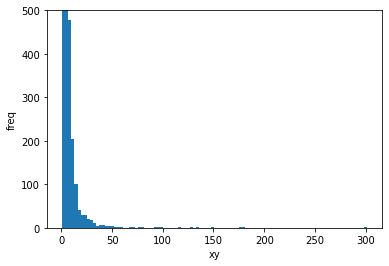

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df_output["sum_count_xy"], bins=100)
ax.set_title('')
ax.set_xlabel('xy')
ax.set_ylabel('freq')
#見辛いのでy軸の範囲を限定します
ax.set_ylim(0,500)
fig.show()

In [11]:
df = df_output.copy()
df = df[df["support_xy"]>=df["support_xy"].quantile(0.98)]
df.head()

,x,y,sum_count_xy,support_xy,support_x,support_y,sum_count_x,sum_count_y,confidence,lift,sum_count
58,662193,667129,8,0.000056,0.003614,0.002811,513,399,0.015595,5.548218,141956
59,665672,667129,12,0.000085,0.003952,0.002811,561,399,0.021390,7.610256,141956
60,666435,667129,30,0.000211,0.008228,0.002811,1168,399,0.025685,9.138171,141956
62,666590,667129,7,0.000049,0.004213,0.002811,598,399,0.011706,4.164642,141956
63,666856,667129,8,0.000056,0.003910,0.002811,555,399,0.014414,5.128352,141956


In [12]:
# 別の方法
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/archive/data.csv', encoding="shift-jis")




from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

CustomerID	=17850
df = df[df.CustomerID == CustomerID]
dataset = df.groupby('InvoiceNo')['StockCode'].apply(list)

dataset

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df2 = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df2, min_support=0.48, use_colnames=True)
frequent_itemsets



rules_mlxtend = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

rules_mlxtend = rules_mlxtend[rules_mlxtend.antecedents == '(71053)'] 
rules_mlxtend



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [13]:
# df = df[df.Country == 'Germany']

# basket = pd.pivot_table(data=df,index='InvoiceNo',columns='Description',values='Quantity', 
#                         aggfunc='sum',fill_value=0)
# df
import pandas as pd


from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

df = pd.read_csv('/content/drive/MyDrive/archive/data.csv', encoding="shift-jis")
df.head()
df.dtypes
# CustomerID	=17850
# df = df[df.CustomerID == CustomerID]
# df

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [14]:
def rules(df,StockCode='None', Country ='None',  InvoiceDate='None', CustomerID	=0 ):
  # df = df[df.Country == Country]
  # df = df[df.InvoiceDate == InvoiceDate] オブジェクト型のせいなのかわからないけど、できなかった
  # df = df[df.CustomerID == CustomerID]
  dataset = df.groupby('InvoiceNo')['StockCode'].apply(list)
  # print(dataset)
  te = TransactionEncoder()
  te_ary = te.fit(dataset).transform(dataset)
  df2 = pd.DataFrame(te_ary, columns=te.columns_)
  frequent_itemsets = apriori(df2, min_support=0.01, use_colnames=True)
  
  rules_mlxtend = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
  rules_mlxtend = rules_mlxtend[rules_mlxtend['antecedents'] ==  {'20711'}]
  return  rules_mlxtend

In [16]:
rules(df)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(20711),(20712),0.020541,0.033668,0.011158,0.543233,16.135019,0.010467,2.115591
2,(20711),(21931),0.020541,0.046371,0.011506,0.560150,12.079846,0.010553,2.168080
4,(20711),(22386),0.020541,0.047529,0.010888,0.530075,11.152679,0.009912,2.026858
6,(20711),(22411),0.020541,0.045830,0.010270,0.500000,10.909857,0.009329,1.908340
8,(20711),(85099B),0.020541,0.082432,0.013436,0.654135,7.935412,0.011743,2.652967
10,(20711),(DOT),0.020541,0.027413,0.010541,0.513158,18.719422,0.009977,1.997746


In [ ]:
# pip install numpy --upgrade